In [1]:
import pandas as pd
df = pd.read_csv('emilia_romagna_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:56:59.731000,VER,1,0 days 00:01:22.881000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:27.949000,...,True,Red Bull Racing,0 days 00:55:36.608000,2024-05-19 13:03:16.594,1,1.0,False,NaN,False,False
1,0 days 00:58:20.327000,VER,1,0 days 00:01:20.596000,2.0,1.0,NaN,NaN,0 days 00:00:25.604000,0 days 00:00:27.925000,...,True,Red Bull Racing,0 days 00:56:59.731000,2024-05-19 13:04:39.717,1,1.0,False,NaN,False,True
2,0 days 00:59:41.199000,VER,1,0 days 00:01:20.872000,3.0,1.0,NaN,NaN,0 days 00:00:25.743000,0 days 00:00:28.104000,...,True,Red Bull Racing,0 days 00:58:20.327000,2024-05-19 13:06:00.313,1,1.0,False,NaN,False,True
3,0 days 01:01:01.870000,VER,1,0 days 00:01:20.671000,4.0,1.0,NaN,NaN,0 days 00:00:25.651000,0 days 00:00:27.991000,...,True,Red Bull Racing,0 days 00:59:41.199000,2024-05-19 13:07:21.185,1,1.0,False,NaN,False,True
4,0 days 01:02:22.604000,VER,1,0 days 00:01:20.734000,5.0,1.0,NaN,NaN,0 days 00:00:25.602000,0 days 00:00:28.041000,...,True,Red Bull Racing,0 days 01:01:01.870000,2024-05-19 13:08:41.856,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,0 days 02:03:07.222000,ALB,23,0 days 00:01:21.347000,47.0,5.0,NaN,NaN,0 days 00:00:25.652000,0 days 00:00:28.493000,...,False,Williams,0 days 02:01:45.875000,2024-05-19 14:09:25.861,1,20.0,False,NaN,False,True
1234,0 days 02:04:28.496000,ALB,23,0 days 00:01:21.274000,48.0,5.0,NaN,NaN,0 days 00:00:25.553000,0 days 00:00:28.534000,...,False,Williams,0 days 02:03:07.222000,2024-05-19 14:10:47.208,1,20.0,False,NaN,False,True
1235,0 days 02:05:52.315000,ALB,23,0 days 00:01:23.819000,49.0,5.0,NaN,NaN,0 days 00:00:25.724000,0 days 00:00:28.633000,...,False,Williams,0 days 02:04:28.496000,2024-05-19 14:12:08.482,1,20.0,False,NaN,False,True
1236,0 days 02:07:14.727000,ALB,23,0 days 00:01:22.412000,50.0,5.0,NaN,NaN,0 days 00:00:26.027000,0 days 00:00:28.903000,...,False,Williams,0 days 02:05:52.315000,2024-05-19 14:13:32.301,1,20.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 63  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              4               9.0          10.200000   
1    ALO              3               8.0          15.500000   
2    BOT              1               9.0          31.000000   
3    GAS              2               9.0          20.666667   
4    HAM              1              28.0          31.500000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000          0.980392         0.019608  
1          0.161290          0.306452         0.532258  
2          0.000000          0.129032         0.870968  
3          0.129032          0.516129         0.354839  
4          0.000000          0.428571         0.571429  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,8.0,0 days 01:06:45.741000,NaN,MEDIUM,8.0,1.0
1,ALB,9.0,0 days 01:09:28.708000,0 days 01:07:15.914000,HARD,1.0,2.0
2,ALB,10.0,NaN,0 days 01:10:01.861000,MEDIUM,1.0,3.0
3,ALB,23.0,0 days 01:29:13.267000,NaN,MEDIUM,14.0,3.0
4,ALB,24.0,NaN,0 days 01:29:51.662000,MEDIUM,15.0,4.0
5,ALB,28.0,0 days 01:36:45.856000,NaN,MEDIUM,19.0,4.0
6,ALB,29.0,NaN,0 days 01:37:16.938000,MEDIUM,9.0,5.0
7,ALB,51.0,0 days 02:08:40.148000,NaN,MEDIUM,31.0,5.0
8,ALO,1.0,NaN,0 days 00:55:49.877000,SOFT,1.0,1.0
9,ALO,7.0,0 days 01:05:29.283000,NaN,SOFT,7.0,1.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,4,9.0,10.200000,0.000000,0.980392,0.019608
1,ALO,3,8.0,15.500000,0.161290,0.306452,0.532258
2,BOT,1,9.0,31.000000,0.000000,0.129032,0.870968
3,GAS,2,9.0,20.666667,0.129032,0.516129,0.354839
4,HAM,1,28.0,31.500000,0.000000,0.428571,0.571429
5,HUL,1,14.0,31.000000,0.000000,0.209677,0.790323
6,LEC,1,26.0,31.500000,0.000000,0.396825,0.603175
7,MAG,1,38.0,31.000000,0.000000,0.596774,0.403226
8,NOR,1,23.0,31.500000,0.000000,0.349206,0.650794
9,OCO,1,26.0,31.000000,0.000000,0.403226,0.596774


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1164


In [9]:
df['Driver'].value_counts()


,count
Driver,
VER,60
NOR,60
LEC,60
PIA,60
SAI,60
HAM,60
PER,60
STR,60
HUL,59


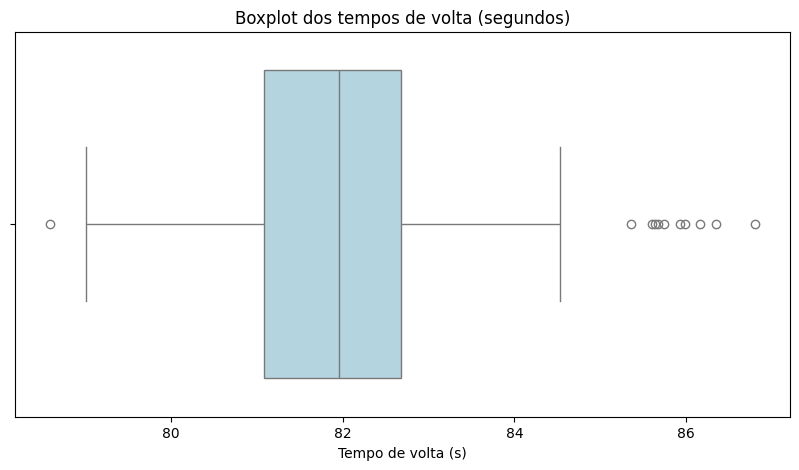

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


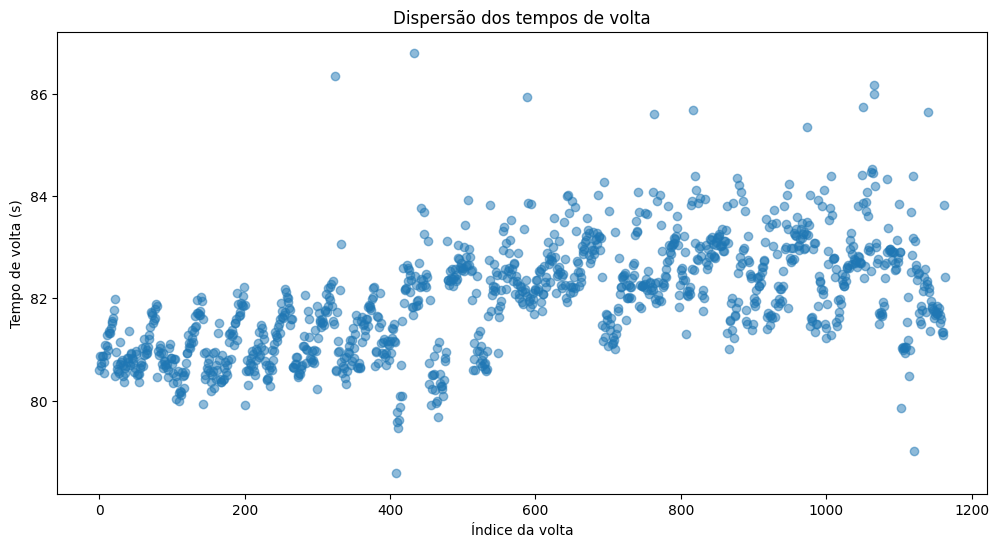

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


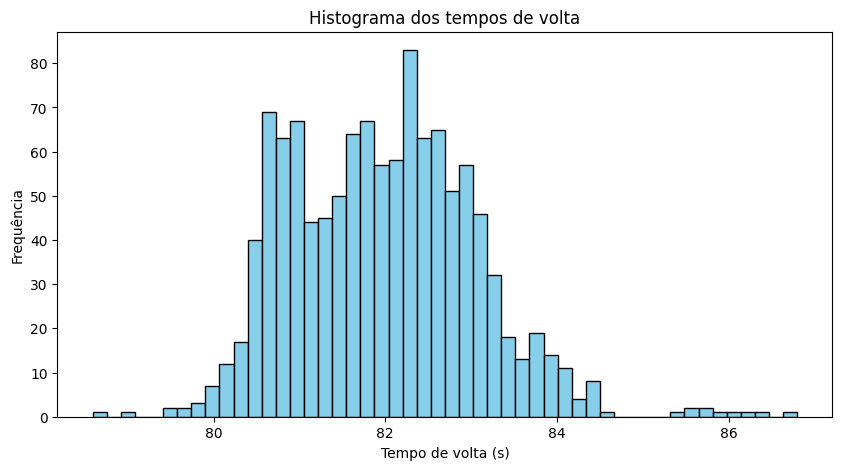

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


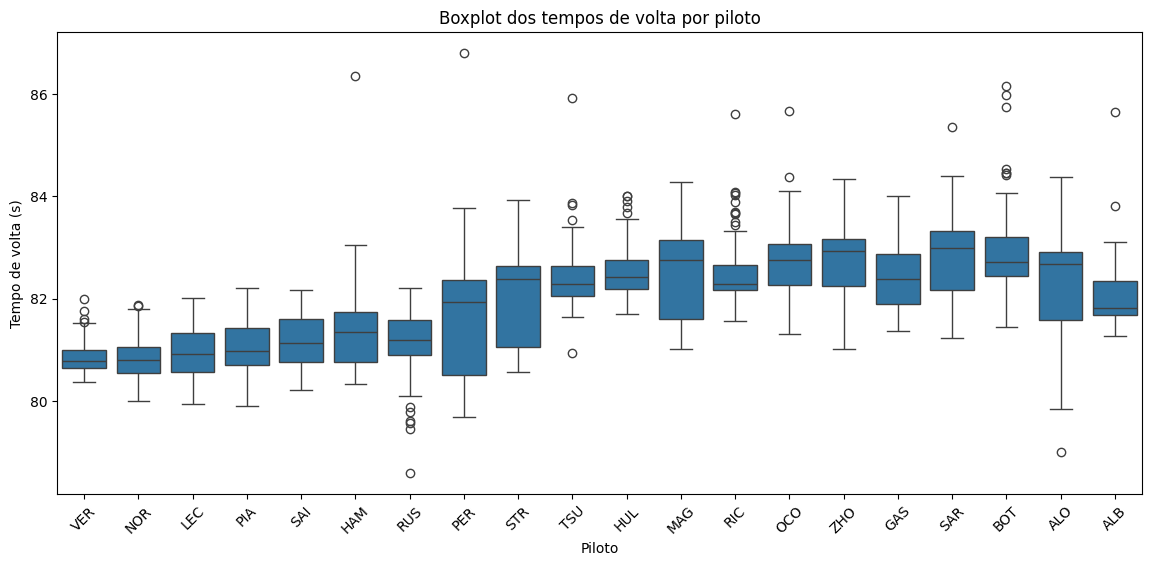

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
RUS   0 days 00:01:18.589000
ALO   0 days 00:01:19.004000
PER   0 days 00:01:19.686000
PIA   0 days 00:01:19.907000
LEC   0 days 00:01:19.935000
NOR   0 days 00:01:19.994000
SAI   0 days 00:01:20.220000
HAM   0 days 00:01:20.331000
VER   0 days 00:01:20.366000
STR   0 days 00:01:20.570000
TSU   0 days 00:01:20.936000
MAG   0 days 00:01:21.009000
ZHO   0 days 00:01:21.016000
SAR   0 days 00:01:21.229000
ALB   0 days 00:01:21.274000
OCO   0 days 00:01:21.304000
GAS   0 days 00:01:21.371000
BOT   0 days 00:01:21.455000
RIC   0 days 00:01:21.569000
HUL   0 days 00:01:21.700000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Emilia Romanha'
race_date = '2024-05-19'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,42,82.078119,0.759826,81.274,85.644,81.8280,4.370,2024,Emilia Romanha,2024-05-19
1,ALO,55,82.289200,1.089005,79.004,84.389,82.6860,5.385,2024,Emilia Romanha,2024-05-19
2,BOT,59,82.986797,0.993260,81.455,86.165,82.7180,4.710,2024,Emilia Romanha,2024-05-19
3,GAS,57,82.433649,0.675815,81.371,84.010,82.3910,2.639,2024,Emilia Romanha,2024-05-19
4,HAM,60,81.393733,0.878600,80.331,86.346,81.3560,6.015,2024,Emilia Romanha,2024-05-19
5,HUL,59,82.566881,0.555013,81.700,84.017,82.4330,2.317,2024,Emilia Romanha,2024-05-19
6,LEC,60,80.959317,0.505099,79.935,82.018,80.9270,2.083,2024,Emilia Romanha,2024-05-19
7,MAG,59,82.476695,0.869489,81.009,84.273,82.7610,3.264,2024,Emilia Romanha,2024-05-19
8,NOR,60,80.856883,0.475637,79.994,81.883,80.8095,1.889,2024,Emilia Romanha,2024-05-19
9,OCO,59,82.810237,0.741334,81.304,85.675,82.7560,4.371,2024,Emilia Romanha,2024-05-19


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,42,82.078119,0.759826,81.274,85.644,81.8280,4.370,2024,Emilia Romanha,2024-05-19,51.0,False
1,ALO,55,82.289200,1.089005,79.004,84.389,82.6860,5.385,2024,Emilia Romanha,2024-05-19,62.0,True
2,BOT,59,82.986797,0.993260,81.455,86.165,82.7180,4.710,2024,Emilia Romanha,2024-05-19,62.0,True
3,GAS,57,82.433649,0.675815,81.371,84.010,82.3910,2.639,2024,Emilia Romanha,2024-05-19,62.0,True
4,HAM,60,81.393733,0.878600,80.331,86.346,81.3560,6.015,2024,Emilia Romanha,2024-05-19,63.0,True
5,HUL,59,82.566881,0.555013,81.700,84.017,82.4330,2.317,2024,Emilia Romanha,2024-05-19,62.0,True
6,LEC,60,80.959317,0.505099,79.935,82.018,80.9270,2.083,2024,Emilia Romanha,2024-05-19,63.0,True
7,MAG,59,82.476695,0.869489,81.009,84.273,82.7610,3.264,2024,Emilia Romanha,2024-05-19,62.0,True
8,NOR,60,80.856883,0.475637,79.994,81.883,80.8095,1.889,2024,Emilia Romanha,2024-05-19,63.0,True
9,OCO,59,82.810237,0.741334,81.304,85.675,82.7560,4.371,2024,Emilia Romanha,2024-05-19,62.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,4,9.0,10.200000,0.000000,0.980392,0.019608
1,ALO,3,8.0,15.500000,0.161290,0.306452,0.532258
2,BOT,1,9.0,31.000000,0.000000,0.129032,0.870968
3,GAS,2,9.0,20.666667,0.129032,0.516129,0.354839
4,HAM,1,28.0,31.500000,0.000000,0.428571,0.571429
5,HUL,1,14.0,31.000000,0.000000,0.209677,0.790323
6,LEC,1,26.0,31.500000,0.000000,0.396825,0.603175
7,MAG,1,38.0,31.000000,0.000000,0.596774,0.403226
8,NOR,1,23.0,31.500000,0.000000,0.349206,0.650794
9,OCO,1,26.0,31.000000,0.000000,0.403226,0.596774


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,42,82.078119,0.759826,81.274,85.644,81.8280,4.370,2024,Emilia Romanha,2024-05-19,51.0,False,4,9.0,10.200000,0.000000,0.980392,0.019608
1,ALO,55,82.289200,1.089005,79.004,84.389,82.6860,5.385,2024,Emilia Romanha,2024-05-19,62.0,True,3,8.0,15.500000,0.161290,0.306452,0.532258
2,BOT,59,82.986797,0.993260,81.455,86.165,82.7180,4.710,2024,Emilia Romanha,2024-05-19,62.0,True,1,9.0,31.000000,0.000000,0.129032,0.870968
3,GAS,57,82.433649,0.675815,81.371,84.010,82.3910,2.639,2024,Emilia Romanha,2024-05-19,62.0,True,2,9.0,20.666667,0.129032,0.516129,0.354839
4,HAM,60,81.393733,0.878600,80.331,86.346,81.3560,6.015,2024,Emilia Romanha,2024-05-19,63.0,True,1,28.0,31.500000,0.000000,0.428571,0.571429
5,HUL,59,82.566881,0.555013,81.700,84.017,82.4330,2.317,2024,Emilia Romanha,2024-05-19,62.0,True,1,14.0,31.000000,0.000000,0.209677,0.790323
6,LEC,60,80.959317,0.505099,79.935,82.018,80.9270,2.083,2024,Emilia Romanha,2024-05-19,63.0,True,1,26.0,31.500000,0.000000,0.396825,0.603175
7,MAG,59,82.476695,0.869489,81.009,84.273,82.7610,3.264,2024,Emilia Romanha,2024-05-19,62.0,True,1,38.0,31.000000,0.000000,0.596774,0.403226
8,NOR,60,80.856883,0.475637,79.994,81.883,80.8095,1.889,2024,Emilia Romanha,2024-05-19,63.0,True,1,23.0,31.500000,0.000000,0.349206,0.650794
9,OCO,59,82.810237,0.741334,81.304,85.675,82.7560,4.371,2024,Emilia Romanha,2024-05-19,62.0,True,1,26.0,31.000000,0.000000,0.403226,0.596774


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoEmiliaRomanha.csv', index=False)
